In [1]:
import numpy as np
import matplotlib.pyplot as plt

import json
import kwant

import codes.trijunction as trijunction
import codes.parameters as parameters
from codes.constants import pairs, bands
from codes.utils import eigsh, dict_update

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


# Initialize trijunction

In [2]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
     # {"device":
     # {"grid_spacing":
     #  {"twoDEG": 1, "normal": 1, "dielectric": 1, "air": 5, "gate": 1, "substrate": 1}}},
    {"gate": {"channel_width": 13.0, "L":40, 'angle': np.pi/6, 'gap': 4}},
    # {"kwant": {"nww":8}},
    
]
for local_config in change_config:
    config = dict_update(config, local_config)

In [3]:
system = trijunction.Trijunction(config, optimize_phase_pairs=[])

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:31<00:00,  2.45s/it]


In [7]:
voltages = parameters.pair_voltages(initial=(-1.0e-3, -1.0e-3, -1.0e-3, 2e-3), depleted=-7e-3)

### Topological gap 

In [8]:
params = parameters.junction_parameters()
params.update(potential=system.flat_potential(2))

In [9]:
num_ham = system.trijunction.hamiltonian_submatrix(
            sparse=True, params=system.f_params(**params)
        )

In [10]:
evasl = eigsh(num_ham, 20)

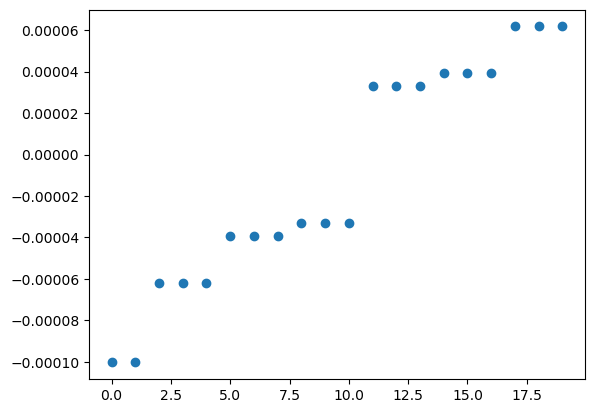

In [11]:
plt.scatter(range(20), evasl)

In [12]:
topo_gap = evasl[14]

In [13]:
topo_gap

3.915110247222383e-05

In [11]:
topo_gap

0.0003249887255233884

# Gap from momentum space 

In [ ]:
mu = codes.parameters.bands[0]

In [ ]:
a = 10e-9

hamiltonian = """( t * (k_x**2 + k_y**2 ) - mu)* kron(sigma_0, sigma_z)
+ alpha * k_x * kron(sigma_y, sigma_z)
- alpha * k_y * kron(sigma_x, sigma_z)
+ Delta_re * kron(sigma_0, sigma_x)
+ Delta_im * kron(sigma_0, sigma_y)
+ B_x * kron(sigma_x, sigma_0)"""

template = kwant.continuum.discretize(hamiltonian, grid=a)

In [ ]:
params = codes.parameters.junction_parameters(0)
params.pop('phi1')
params.pop('phi2')
params.pop('sigma')
params.pop('a')
params.pop('mus_nw')
Delta = params.pop('Delta')
params.update(mu=mu)
params.update(Delta_re=Delta)
params.update(Delta_im=0)
params

In [ ]:
wire_width = 7 * a

In [ ]:
lead = kwant.Builder(symmetry=kwant.TranslationalSymmetry([-a, 0]))
lead.fill(template, shape=lambda site: 0 <= site.pos[1] < wire_width, start=[0]);

In [ ]:
kwant.plot(lead)

In [ ]:
ks = np.linspace(-1, 1, 500)

In [ ]:
fig, ax = plt.subplots()
kwant.plotter.bands(lead.finalized(), show=False, params=params, ax=ax, momenta=ks);
bands = []
ax.set_ylim(-100e-5, 100e-5)
ax.set_ylabel('E[eV]')
ax.set_xlabel('k_x')

In [ ]:
for line in ax.lines:
    ks, band_data = line.get_data()
    bands.append(band_data)
bands = np.array(bands)

In [ ]:
topo_gap = np.min(np.abs(bands))
topo_gap